In [15]:
import numpy as np 
import pandas as pd

import laspy

from geopandas import GeoDataFrame
from shapely.geometry import Polygon,Point
import plotly.offline as go_offline
import plotly.graph_objects as go
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [16]:
try:
    inFile = laspy.read('../laz/iowa.las')
except FileNotFoundError:
    print("File not Found")
    
lidar_points = np.array((inFile.x,inFile.y,inFile.z,inFile.intensity,
               inFile.raw_classification,inFile.scan_angle_rank)).transpose()

#Transform to pandas DataFrame
lidar_df=pd.DataFrame(lidar_points)

In [17]:
lidar_df.head()

,0,1,2,3,4,5
0,438030.48,4641321.84,318.49,2.0,2.0,-12.0
1,438029.54,4641321.56,318.37,34.0,2.0,-12.0
2,438028.53,4641321.81,318.41,37.0,2.0,-12.0
3,438018.94,4641322.50,318.15,2.0,2.0,-12.0
4,438019.93,4641322.27,318.29,2.0,2.0,-12.0


In [18]:
#rename column names 
lidar_df.columns = ["x","y","z","intensity","raw_classification","scan_angle_rank"]

In [19]:
lidar_df.tail(10)

,x,y,z,intensity,raw_classification,scan_angle_rank
401274,437297.95,4641033.93,310.41,2.0,2.0,14.0
401275,437312.49,4641030.11,310.56,2.0,2.0,13.0
401276,437320.82,4641027.93,310.76,2.0,2.0,13.0
401277,437305.53,4641029.97,310.44,46.0,2.0,13.0
401278,437297.25,4641032.13,310.43,64.0,2.0,14.0
401279,437302.07,4641030.52,310.22,2.0,2.0,13.0
401280,437304.22,4641029.98,310.50,2.0,2.0,13.0
401281,437306.18,4641027.41,310.41,48.0,2.0,13.0
401282,437304.09,4641027.95,310.41,51.0,2.0,13.0
401283,437301.93,4641028.16,310.59,2.0,2.0,13.0


In [20]:
#Transform to geopandas GeoDataFrame
crs = None
geometry = [Point(xy) for xy in zip(inFile.x,inFile.y)]

lidar_geodf = GeoDataFrame(lidar_df, crs=crs, geometry=geometry)
lidar_geodf.crs = {'init' :'epsg:2959'} # set correct spatial reference

In [21]:
lidar_geodf.tail()

,x,y,z,intensity,raw_classification,scan_angle_rank,geometry
401279,437302.07,4641030.52,310.22,2.0,2.0,13.0,POINT (437302.070 4641030.520)
401280,437304.22,4641029.98,310.50,2.0,2.0,13.0,POINT (437304.220 4641029.980)
401281,437306.18,4641027.41,310.41,48.0,2.0,13.0,POINT (437306.180 4641027.410)
401282,437304.09,4641027.95,310.41,51.0,2.0,13.0,POINT (437304.090 4641027.950)
401283,437301.93,4641028.16,310.59,2.0,2.0,13.0,POINT (437301.930 4641028.160)


In [22]:
#turn feet to meters 
lidar_geodf = lidar_geodf.assign(x = lambda x:(x['x']*0.305))
lidar_geodf = lidar_geodf.assign(y = lambda x:(x['y']*0.305))
lidar_geodf = lidar_geodf.assign(z = lambda x:(x['z']*0.305))

In [23]:
#select x,y,z and save to csv file
coordinates = lidar_geodf[['x','y','z']]
coordinates 
#save the first 2000 rows because of lack of computing power when rendering 3D
coordinates[:2000].to_csv('../data/coordinates_in_meters.csv')

##Terrain Visualization

In [24]:
file=open('../data/coordinates_in_meters.csv','r')
lines=file.readlines()
n_line=len(lines)
x=[]
y=[]
z=[]
for i in range(1,n_line):
    split_line=lines[i].split(",")
    xyz_t=[]
    x.append(float(split_line[0].rstrip()))
    y.append(float(split_line[1].rstrip()))
    z.append(float(split_line[2].rstrip()))

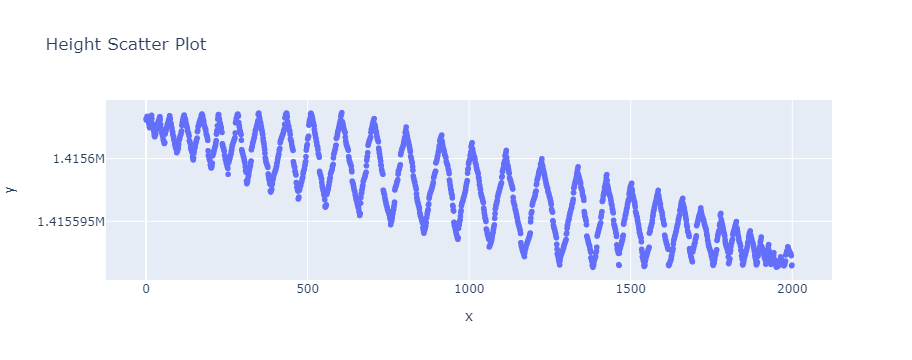

In [25]:
fig = px.scatter(x=x, y=z,title= "Height Scatter Plot")
#fig.title("Height Scatter Plot")
fig.show()

In [26]:
#This code has been taken from www.geodose.com

#DISTANCE FUNCTION
def distance(x1,y1,x2,y2):
    d=np.sqrt((x1-x2)**2+(y1-y2)**2)
    return d

#CREATING IDW FUNCTION
def idw_npoint(xz,yz,n_point,p):
    r=10 #block radius iteration distance
    nf=0
    while nf<=n_point: #will stop when np reaching at least n_point
        x_block=[]
        y_block=[]
        z_block=[]
        r +=10 # add 10 unit each iteration
        xr_min=xz-r
        xr_max=xz+r
        yr_min=yz-r
        yr_max=yz+r
        for i in range(len(x)):
            # condition to test if a point is within the block
            if ((x[i]>=xr_min and x[i]<=xr_max) and (y[i]>=yr_min and y[i]<=yr_max)):
                x_block.append(x[i])
                y_block.append(y[i])
                z_block.append(z[i])
        nf=len(x_block) #calculate number of point in the block
    
    #calculate weight based on distance and p value
    w_list=[]
    for j in range(len(x_block)):
        d=distance(xz,yz,x_block[j],y_block[j])
        if d>0:
            w=1/(d**p)
            w_list.append(w)
            z0=0
        else:
            w_list.append(0) #if meet this condition, it means d<=0, weight is set to 0
    
    #check if there is 0 in weight list
    w_check=0 in w_list
    if w_check==True:
        idx=w_list.index(0) # find index for weight=0
        z_idw=z_block[idx] # set the value to the current sample value
    else:
        wt=np.transpose(w_list)
        z_idw=np.dot(z_block,wt)/sum(w_list) # idw calculation using dot product
    return z_idw

In [27]:
import itertools
# POPULATE INTERPOLATION POINTS
n=100 #number of interpolation point for x and y axis
x_min=min(x)
x_max=max(x)
y_min=min(y)
y_max=max(y)
w=x_max-x_min #width
h=y_max-y_min #length
wn=w/n #x interval
hn=h/n #y interval

#list to store interpolation point and elevation
y_init=y_min
x_init=x_min
x_idw_list=[]
y_idw_list=[]
z_head=[]
for i in range (n):
    xz=x_init+wn*i
    yz=y_init+hn*i
    y_idw_list.append(yz)
    x_idw_list.append(xz)
    z_idw_list=[]
    for j in range(n):
        xz=x_init+wn*j
        z_idw=idw_npoint(xz,yz,5,1.5) #min. point=5, p=1.5
        z_idw_list.append(z_idw)
    z_head.append(z_idw_list)

In [28]:
# CREATING 3D TERRAIN MODEL
fig=go.Figure()
fig.add_trace(go.Surface(z=z_head,x=x_idw_list,y=y_idw_list))
fig.update_layout(scene=dict(aspectratio=dict(x=2, y=2, z=0.5),xaxis = dict(range=[x_min,x_max],),yaxis = dict(range=[y_min,y_max])))
go_offline.plot(fig,filename='../3D/3d_terrain.html',validate=True, auto_open=False)

'../3D/3d_terrain.html'